In [50]:
import os
import re
import ast
import datetime
import numpy as np
import pandas as pd
import faiss
import pickle
import gc
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from transformers import AutoModel
from transformers import AutoProcessor
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
df = pd.read_csv(r"combined_csv\df_combs.csv")

In [3]:
df['brand'] = df['brand'].apply(lambda x: x.lower())

In [5]:
df["category_id"] = df["category_id"].map({30: 'dresses', 56: 'jeans'})
df["department_id"] = df["department_id"].map({2: "women's apparel"})

In [6]:
df.head()

,selling_price,discount,category_id,meta_info,product_id,pdp_url,sku,brand,department_id,last_seen_date,launch_on,mrp,product_name,feature_image_s3,channel_id,feature_list,description,style_attributes,pdp_images_s3
0,{'INR': 474848.9539},0.0,dresses,Slim fit. Designed to hit at the ankle. UK siz...,b613d7b5dfe86f3e695d931d31fd729fdf44e181f14079...,https://www.ralphlauren.co.uk/en/kristian-silk...,479495,ralph lauren,women's apparel,5/1/2025,2/29/2020,{'INR': 474848.9539},Kristian Silk Tuxedo Dress,https://gallery.stylumia.com/originals/2020/02...,14,"['Slim fit. Designed to hit at the ankle.', 'U...",The Kristian evening dress is informed by the ...,{},['https://gallery.stylumia.com/originals/2020/...
1,{'INR': 464648.6919},0.0,dresses,Slim fit. Designed to hit at the ankle. UK siz...,482b10a23f8d00cfc7c9bbeeac4e26d25dd303d8e62e97...,https://www.ralphlauren.co.uk/en/kristian-silk...,502670,ralph lauren,women's apparel,5/8/2025,2/29/2020,{'INR': 464648.6919},Kristian Silk Tuxedo Dress,https://gallery.stylumia.com/originals/2020/02...,14,"['Slim fit. Designed to hit at the ankle.', 'U...",The Kristian evening dress is informed by the ...,{},['https://gallery.stylumia.com/originals/2020/...
2,{'INR': 29496.0812},0.0,dresses,Fit-and-flare silhouette. Intended to hit at t...,3508b052ef7a5eea820423b97713612bc92a3f2301a3d3...,https://www.ralphlauren.co.uk/en/fit-and-flare...,478766,ralph lauren,women's apparel,5/8/2025,2/29/2020,{'INR': 29496.0812},Fit-and-Flare Shirtdress,https://gallery.stylumia.com/originals/2020/02...,14,['Fit-and-flare silhouette. Intended to hit at...,Airy georgette and a flattering fit-and-flare ...,{},['https://gallery.stylumia.com/originals/2020/...
3,{'INR': 17156.9392},0.0,dresses,"Fits true to size; take your normal size, Stra...",6360245240b68885bd4dbcef8d8856c0fb13f1314769f5...,https://www.anthropologie.com/shop/adena-crepe...,50297209_041,bhldn,women's apparel,1/31/2025,5/27/2020,{'INR': 17156.9392},Adena Crepe Dress,https://gallery.stylumia.com/originals/2020/05...,48,"['Back zip', 'Polyester; polyester lining', 'P...","A sleek square neckline tops this stretchy, bo...","{'modelNotes': '', 'dimensions': 'Fits true to...",['https://gallery.stylumia.com/originals/2020/...
4,{'INR': 26079.5467},0.0,dresses,Fit-and-flare silhouette Designed to hit at th...,5d07037957e64d1e218499cb7d7a8e5e57aa59249bb806...,https://www.ralphlauren.co.uk/en/belted-cotton...,478750,ralph lauren,women's apparel,5/8/2025,2/12/2021,{'INR': 26079.5467},Belted Cotton-Blend Shirtdress,https://gallery.stylumia.com/originals/2021/02...,14,['Fit-and-flare silhouette Designed to hit at ...,This iteration of Lauren's iconic shirtdress i...,{},['https://gallery.stylumia.com/originals/2021/...


In [7]:
num_unique = df['product_name'].nunique()

unique_values = df['product_name'].unique()

value_counts = df['product_name'].value_counts()

print(f"Number of unique values: {num_unique}")
print(f"Unique values: {unique_values}")
print(f"Value counts:\n{value_counts}")

top_counts = df['product_name'].value_counts().head(100)

print(top_counts)

Number of unique values: 12553
Unique values: ['Kristian Silk Tuxedo Dress' 'Fit-and-Flare Shirtdress'
 'Adena Crepe Dress' ... 'Wide-leg striped jeans'
 'High-waist wide-leg jeans with seam details'
 'Petite Straight-Leg Turn-Up Jeans in Mid Blue']
Value counts:
product_name
LADIES` DRESS                                                       113
LADIES` JEANS TROUSERS                                               65
Wide leg jeans                                                       45
Midi dress                                                           39
Knit maxi dress                                                      22
                                                                   ... 
Figure Form Bandage Plunge Neck Sleeveless Knit Mini Dress            1
Viscose Metallic Georgette Halter Woven Maxi Dress                    1
Tall Figure Form Bandage Knit Embellished Wide Sleeve Maxi Dress      1
The Founder Soft Touch Jersey Asymmetric Neck Midi Dress              1
Pet

In [8]:
df['blobbed_text'] = df['category_id'] +' . ' + df['brand'] + ' . ' + df['department_id'] + ' . ' + df['product_name']

In [9]:
class PriceEncode(nn.Module):
    def __init__(self, hidden_dim=32, out_dim=64, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )
    
    def forward(self, price_raw, min_price, max_price):
        # Ensure min/max are tensors on correct device
        min_price = torch.tensor(min_price, dtype=price_raw.dtype, device=price_raw.device)
        max_price = torch.tensor(max_price, dtype=price_raw.dtype, device=price_raw.device)
        
        # Clamp prices to avoid negative values
        price_raw = torch.clamp(price_raw, min=0)
        min_price = torch.clamp(min_price, min=0)
        max_price = torch.clamp(max_price, min=0)
        
        # Log-transform with stabilization
        x = torch.log(price_raw + self.eps).unsqueeze(-1)  # [N,1]
        
        # Compute log values with same stabilization
        log_min = torch.log(min_price + self.eps)
        log_max = torch.log(max_price + self.eps)
        
        # Compute denominator with numerical stability
        denom = log_max - log_min
        denom = torch.where(denom.abs() < 1e-12, torch.ones_like(denom), denom)
        
        # Min-max scaling with safe division
        x_scaled = (x - log_min) / denom
        
        # Replace any out-of-bound values
        x_scaled = torch.clamp(x_scaled, 0, 1)
        
        # MLP processing
        x = self.net(x_scaled)
        
        # L2 normalization
        return F.normalize(x, p=2, dim=-1)

In [10]:
# Preprocessing with data validation
df['selling_price'] = pd.to_numeric(df['selling_price'], errors='coerce').fillna(0)
min_price = float(df['selling_price'].min())
max_price = float(df['selling_price'].max())

# Handle case where min_price == max_price
if min_price == max_price:
    max_price = min_price + 1  # Prevent division by zero

selling_price = torch.tensor(df['selling_price'].values, dtype=torch.float32)

In [11]:
priceprocess = PriceEncode()
price_embedding = priceprocess.forward(selling_price, min_price, max_price)

In [12]:
price_embedding.shape

torch.Size([17483, 64])

In [13]:
price_embedding

tensor([[-0.0405, -0.0899,  0.1472,  ...,  0.1686,  0.0651, -0.0130],
        [-0.0405, -0.0899,  0.1472,  ...,  0.1686,  0.0651, -0.0130],
        [-0.0405, -0.0899,  0.1472,  ...,  0.1686,  0.0651, -0.0130],
        ...,
        [-0.0405, -0.0899,  0.1472,  ...,  0.1686,  0.0651, -0.0130],
        [-0.0405, -0.0899,  0.1472,  ...,  0.1686,  0.0651, -0.0130],
        [-0.0405, -0.0899,  0.1472,  ...,  0.1686,  0.0651, -0.0130]],
       grad_fn=<DivBackward0>)

In [14]:
model = AutoModel.from_pretrained("Marqo/marqo-fashionSigLIP", trust_remote_code=True)
processor = AutoProcessor.from_pretrained('Marqo/marqo-fashionSigLIP', trust_remote_code=True)

You are using a model of type siglip to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


In [16]:
# torch.save(embeddings_dict, "less_text_embeddings.pt")

In [17]:
# assuming you saved with torch.save()
img_vecs  = torch.load(r"all_embeds\dresses_jeans_combine_embeds\combined_embeddings.pt")
meta_vecs = torch.load(r"all_embeds\less_text_embeddings.pt")

# common product IDs (strings)
common_pids = list(set(img_vecs.keys()) & set(meta_vecs.keys()))
# map each pid string to a numeric label for contrastive loss
label_map = {pid: idx for idx, pid in enumerate(common_pids)}

In [18]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
LR = 1e-4
EPOCHS = 10
TEMPERATURE = 0.07

In [19]:
class FusionDataset(Dataset):
    def __init__(self, pids, img_dict, meta_dict, label_map):
        self.pids      = pids
        self.imgs      = img_dict
        self.metas     = meta_dict
        self.label_map = label_map

    def __len__(self):
        return len(self.pids)

    def __getitem__(self, idx):
        pid      = self.pids[idx]
        img_vec  = self.imgs[pid].float()    # Tensor[768]
        meta_vec = self.metas[pid].float()   # Tensor[768]
        label    = self.label_map[pid]       # int
        return {
            "img":   img_vec,
            "meta":  meta_vec,
            "pid":   pid,
            "label": label
        }

dataset = FusionDataset(common_pids, img_vecs, meta_vecs, label_map)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [23]:
raw_img  = torch.load(r"all_embeds\dresses_jeans_combine_embeds\combined_embeddings.pt")
raw_meta = torch.load(r"all_embeds\less_text_embeddings.pt")

In [24]:
# # Normalize keys to str for both dicts
img_vecs = {str(pid): vec for pid, vec in raw_img.items()}
meta_vecs = {str(pid): vec for pid, vec in raw_meta.items()}

In [27]:
# Re-define FusionHead to project image and meta vectors separately
class FusionHead(nn.Module):
    def __init__(self, in_dim=768, out_dim=512):
        super().__init__()
        self.img_fc = nn.Linear(in_dim, out_dim)
        self.meta_fc = nn.Linear(in_dim, out_dim)
        self.norm = nn.LayerNorm(out_dim)

    def forward(self, img_vec, meta_vec):
        img_proj = F.relu(self.img_fc(img_vec))
        meta_proj = F.relu(self.meta_fc(meta_vec))
        return self.norm(img_proj), self.norm(meta_proj) # Return two separate projected embeddings

# Re-define info_nce_loss to take two sets of embeddings for cross-modal contrastive learning
def info_nce_loss(img_emb, text_emb, temperature=TEMPERATURE):
    # Normalize embeddings
    img_emb = F.normalize(img_emb, dim=-1)
    text_emb = F.normalize(text_emb, dim=-1)
    
    # Compute similarity matrix
    logits_per_image = img_emb @ text_emb.t() / temperature
    logits_per_text = text_emb @ img_emb.t() / temperature
    
    # Labels are diagonal (matching pairs)
    batch_size = img_emb.shape[0]
    labels = torch.arange(batch_size, device=img_emb.device)
    
    # Cross-entropy losses
    loss_i = F.cross_entropy(logits_per_image, labels)
    loss_t = F.cross_entropy(logits_per_text, labels)
    
    return (loss_i + loss_t) / 2

# Instantiate the model and optimizer
fusion = FusionHead().to(DEVICE)
optimizer = optim.AdamW(fusion.parameters(), lr=LR)

for epoch in range(EPOCHS):
    fusion.train()
    total_loss = 0.0
    print(f"Epoch {epoch+1}/{EPOCHS}")
    batch_count = 0
    for batch in tqdm(loader, desc=f"Training Epoch {epoch+1}"):
        img_input = batch['img'].to(DEVICE)   # [B,768]
        meta_input = batch['meta'].to(DEVICE) # [B,768]
        # 'labels' from batch['label'] are product IDs, not needed for this info_nce_loss
        # as it implicitly assumes positive pairs are at the same index within the batch

        # Get projected embeddings for image and metadata
        img_proj, meta_proj = fusion(img_input, meta_input)  # Each [B,512]

        # Calculate InfoNCE loss between image and metadata projections
        loss = info_nce_loss(img_proj, meta_proj, temperature=TEMPERATURE)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_count += 1
    print(f"Processed {batch_count} batches.")
    avg_loss = total_loss / (batch_count or 1)
    print(f"Loss: {avg_loss:.4f}\\n")

Epoch 1/10


Training Epoch 1: 100%|██████████| 274/274 [00:05<00:00, 47.81it/s]


Processed 274 batches.
Loss: 1.4381\n
Epoch 2/10


Training Epoch 2: 100%|██████████| 274/274 [00:07<00:00, 38.78it/s]


Processed 274 batches.
Loss: 0.5762\n
Epoch 3/10


Training Epoch 3: 100%|██████████| 274/274 [00:07<00:00, 37.05it/s]


Processed 274 batches.
Loss: 0.4294\n
Epoch 4/10


Training Epoch 4: 100%|██████████| 274/274 [00:06<00:00, 39.52it/s]


Processed 274 batches.
Loss: 0.3539\n
Epoch 5/10


Training Epoch 5: 100%|██████████| 274/274 [00:05<00:00, 49.05it/s]


Processed 274 batches.
Loss: 0.2964\n
Epoch 6/10


Training Epoch 6: 100%|██████████| 274/274 [00:05<00:00, 51.88it/s]


Processed 274 batches.
Loss: 0.2597\n
Epoch 7/10


Training Epoch 7: 100%|██████████| 274/274 [00:05<00:00, 54.08it/s]


Processed 274 batches.
Loss: 0.2273\n
Epoch 8/10


Training Epoch 8: 100%|██████████| 274/274 [00:05<00:00, 52.95it/s]


Processed 274 batches.
Loss: 0.2028\n
Epoch 9/10


Training Epoch 9: 100%|██████████| 274/274 [00:04<00:00, 60.76it/s]


Processed 274 batches.
Loss: 0.1845\n
Epoch 10/10


Training Epoch 10: 100%|██████████| 274/274 [00:04<00:00, 58.13it/s]

Processed 274 batches.
Loss: 0.1685\n


In [29]:
# ===== Step 6: Encode Full Catalog =====
fusion.eval()
all_vectors, all_pids = [], []
with torch.no_grad():
    for pid in common_pids:
        img_vec  = img_vecs[pid].to(DEVICE)
        meta_vec = meta_vecs[pid].to(DEVICE)
        
        # Get both projected embeddings from the modified FusionHead
        img_proj, meta_proj = fusion(img_vec.unsqueeze(0), meta_vec.unsqueeze(0)) # Each [1,512]

        # Combine the projected embeddings into a single representation for FAISS
        # Averaging is a common way to combine aligned embeddings
        z = (img_proj + meta_proj) / 2  # [1,512]
        
        all_vectors.append(z.cpu().numpy())
        all_pids.append(pid)  # keep string IDs
all_vectors = np.vstack(all_vectors).astype('float32')  # [N,512]

In [31]:
# ===== Step 7: Build & Save FAISS Index =====
faiss.normalize_L2(all_vectors)
index = faiss.IndexHNSWFlat(512, 32)
index.hnsw.efConstruction = 200
index.add(all_vectors)
faiss.write_index(index, 'fashion_fusion.index')
with open('pid_map.pkl', 'wb') as f:
    pickle.dump(all_pids, f)

In [32]:
# ===== Step 8: Inference Function =====
def retrieve(query_img_vec, query_meta_vec, k=5):
    """
    query_img_vec: Tensor[768]
    query_meta_vec: Tensor[768]
    returns: list of top-k product_id strings
    """
    fusion.eval()
    with torch.no_grad():
        # Get both projected embeddings for the query
        q_img_proj, q_meta_proj = fusion(
            query_img_vec.unsqueeze(0).to(DEVICE),
            query_meta_vec.unsqueeze(0).to(DEVICE)
        )
        # Combine them into a single query vector for search
        z_q = ((q_img_proj + q_meta_proj) / 2).cpu().numpy()  # [1,512]

    faiss.normalize_L2(z_q)
    index = faiss.read_index('fashion_fusion.index')
    pids  = pickle.load(open('pid_map.pkl', 'rb'))

    D, I = index.search(z_q, k)
    return [pids[i] for i in I[0]]

In [35]:
#  Example usage:
# Make sure 'some_pid' is a valid product ID from your common_pids
q_img = img_vecs['000bc73f350c619522f89708e16d7f395ca0678143abf41ee677958ea36ab7eb'] ; q_meta = meta_vecs['00a0f20d9afc4be926ad507a2f8c1088cea0e39dc0a2554eba38e60657102031']
print(retrieve(q_img, q_meta, k=5))

['00a0f20d9afc4be926ad507a2f8c1088cea0e39dc0a2554eba38e60657102031', '248f6035ca4f5b4ce93b2c4ae5bc1c7e8323f85ce51f320202f95f51be8bbba6', '49ceec5d1cccc8cbb743553956a16f561903d3f2ffc4b5c2f5763cf84f2382e4', 'c9bb76153cfbb2ade06d20e2a09bc0161a82a23ed6b80caea8e3168c604d9d1d', '55d8995b3e153fe4adc1e7f2713295fb322a1b07611c8b00fc4c1d1731301560']


In [37]:
img_root = r"D:\Fashion recommends\all_images"

In [46]:
# Create a dictionary mapping product_id to full image file path
image_paths_map = {
    row['product_id']: os.path.join(img_root, row['product_id'], f"{row['product_id']}_1.jpg")
    for _, row in df.iterrows()
}

In [51]:
def plot_retrieved_images(retrieved_pids, image_paths_map, num_cols=5):
    """
    Plots the images corresponding to a list of retrieved product IDs.

    Args:
        retrieved_pids (list): A list of product_id strings.
        image_paths_map (dict): A dictionary mapping product_id to its full image file path.
        num_cols (int): Number of columns in the subplot grid.
    """
    num_images = len(retrieved_pids)
    if num_images == 0:
        print("No images to plot.")
        return

    num_rows = (num_images + num_cols - 1) // num_cols # Calculate rows needed (ceiling division)

    plt.figure(figsize=(num_cols * 3, num_rows * 3)) # Adjust figure size based on number of images

    for i, pid in enumerate(retrieved_pids):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        image_path = image_paths_map.get(pid)

        if image_path and os.path.exists(image_path):
            try:
                img = Image.open(image_path).convert('RGB')
                plt.imshow(img)
                plt.title(f"ID: {pid}", fontsize=8) # Display product ID as title
                plt.axis('off') # Hide axes
            except Exception as e:
                print(f"Error loading image {image_path} for PID {pid}: {e}")
                plt.title(f"Error for {pid}", fontsize=8)
                plt.axis('off')
        else:
            plt.title(f"Image not found for {pid}", fontsize=8)
            plt.axis('off')

    plt.tight_layout() # Adjust subplot params for a tight layout
    plt.show() # Display the plot

Querying for product ID: 41ecaf151a9c5a0b875617f58150bef4b652df2554d57d8d1a2ba2c0a6db2509
Retrieved Product IDs: ['41ecaf151a9c5a0b875617f58150bef4b652df2554d57d8d1a2ba2c0a6db2509', '209c8ecf2643fa36114cecd06d30c9af89cb574ac49b0b54a0593b52d5daa944', 'ffd707a91d38c76f93400d644adbd3297fe3a7ddba3a4cc9e51d625c6a885a6f', 'a141c2c3337f0f686c6bcb2113ca46606e0b602ed91050195636477631907558', 'e13cba4f093364ad0d8eeae75dc38ebdf89dc85c431ced1974fb89589948d66f']


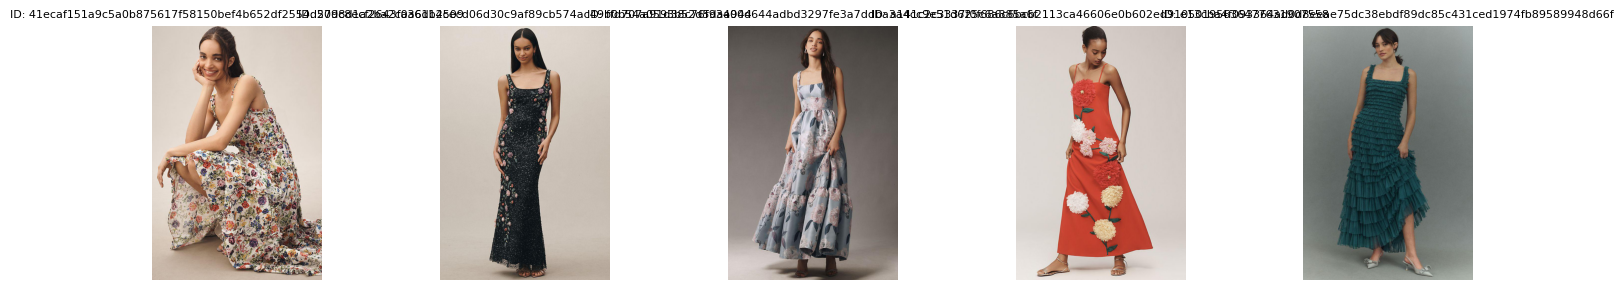

In [54]:
# Choose a product ID from your common_pids to use as a query
example_pid = common_pids[2] # Using the first common product ID as an example
q_img = img_vecs[example_pid]
q_meta = meta_vecs[example_pid]

print(f"Querying for product ID: {example_pid}")

# Retrieve top-k product IDs
retrieved_pids = retrieve(q_img, q_meta, k=5)
print("Retrieved Product IDs:", retrieved_pids)

# Plot the retrieved images
plot_retrieved_images(retrieved_pids, image_paths_map)

In [55]:
# Assuming 'fusion' is your trained FusionHead model instance
# and 'DEVICE' is your device (cuda or cpu)

# After your training loop (e.g., after the last epoch completes):
print("Saving trained FusionHead model...")
torch.save(fusion.state_dict(), 'fusion_model.pth')
print("FusionHead model saved as 'fusion_model.pth'.")

Saving trained FusionHead model...
FusionHead model saved as 'fusion_model.pth'.
